In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
# Load useful libraries
import numpy as np
import pandas as pd
import os
import tqdm
import pathlib
import time
import pickle
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

# Model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Classifiers
import xgboost as xgb
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, \
                            TimeDistributed, GRU, Dropout, Bidirectional, \
                            Conv1D, BatchNormalization
from tensorflow.keras.optimizers import SGD

from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import median_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, classification_report 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# special matplotlib command for global plot configuration
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import requests
from io import BytesIO
import seaborn

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.graphics.api as smg
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from scipy.signal import periodogram

In [4]:
#This cell is only required because I am working on google colab

from google.colab import drive
drive.mount('/content/drive')

MWRA_DATA_FILE=("/content/drive/MyDrive/109b/data-20210430.csv")
MASS_COVID_DATA_FILE=("/content/drive/MyDrive/109b/covid-19-raw-data-4-30-2021.xlsx")

Mounted at /content/drive


In [5]:
#If you are not working on google colab, uncomment this cell, comment out the previous cell and proceed forward
"""
DATA_DIR="../datasets/"

MWRA_DATA_DIR=os.path.join(DATA_DIR, "mwra")
MWRA_DATA_FILE=os.path.join(MWRA_DATA_DIR, "data-20210430.csv")

MASS_COVID_DATA_DIR=os.path.join(DATA_DIR, "mass-covid")
MASS_COVID_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-4-30-2021.xlsx")
"""

'\nDATA_DIR="../datasets/"\n\nMWRA_DATA_DIR=os.path.join(DATA_DIR, "mwra")\nMWRA_DATA_FILE=os.path.join(MWRA_DATA_DIR, "data-20210430.csv")\n\nMASS_COVID_DATA_DIR=os.path.join(DATA_DIR, "mass-covid")\nMASS_COVID_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-4-30-2021.xlsx")\n'

In [6]:
# Load MWRA dataset
df_mwra = pd.read_csv(MWRA_DATA_FILE, parse_dates=['Date'])
display(df_mwra.tail(5))
df_mwra.interpolate(method="akima", limit_direction='both', inplace=True)

# Fill remaining values with 0
df_mwra.fillna(0, inplace=True)

,Date,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval,Southern Variant Results,Northern Variant Results
420,2021-04-25,238.0,176.0,229.0,133.0,75.0,110.0,56.0,81.0,63%,60%
421,2021-04-26,209.0,154.0,235.0,130.0,66.0,96.0,49.0,71.0,64%,49%
422,2021-04-27,139.0,107.0,223.0,126.0,44.0,64.0,34.0,49.0,59%,58%
423,2021-04-28,157.0,102.0,215.0,118.0,50.0,72.0,32.0,47.0,NaN,NaN
424,2021-04-29,231.0,133.0,202.0,122.0,73.0,107.0,42.0,61.0,NaN,NaN


In [7]:
df_mwra.isna().sum()

Date                                 0
Southern (copies/mL)                 0
Northern (copies/mL)                 0
Southern 7 day avg                   0
Northern 7 day avg                   0
Southern Low Confidence  Interval    0
Southern High Confidence Interval    0
Northern Low Confidence Interval     0
Northern High Confidence Interval    0
Southern Variant Results             0
Northern Variant Results             0
dtype: int64

In [8]:
# Describe the dataset
df_mwra.describe()

,Southern (copies/mL),Northern (copies/mL),Southern 7 day avg,Northern 7 day avg,Southern Low Confidence Interval,Southern High Confidence Interval,Northern Low Confidence Interval,Northern High Confidence Interval
count,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,294.843623,266.886846,272.633984,255.798335,86.204706,126.032941,74.644706,109.068235
std,383.722752,313.458548,314.903703,277.811360,124.252417,181.671572,99.294865,145.142391
min,-3.236515,-133.414654,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,44.000000,43.000000,48.000000,5.000000,8.000000,7.000000,10.000000
50%,164.000000,167.000000,136.000000,155.000000,32.000000,47.000000,34.000000,49.000000
75%,390.000000,360.000000,374.000000,332.000000,118.000000,173.000000,100.000000,146.000000
max,3772.000000,1451.000000,1476.000000,1130.000000,1192.000000,1743.000000,458.000000,670.000000


Text(0.5, 1.05, 'Relationship plot between Southern and Northern Viral Titers')

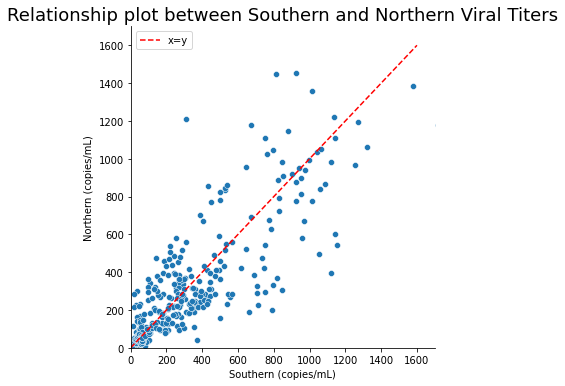

In [9]:
# Show the relation between norther and souther samples
sns.relplot(data=df_mwra, x="Southern (copies/mL)", y="Northern (copies/mL)")
plt.plot([0,1600], [0,1600], '--r', label="x=y")
plt.xlim([0, 1700])
plt.ylim([0, 1700])
plt.legend()
plt.title('Relationship plot between Southern and Northern Viral Titers', fontsize=18, y=1.05)

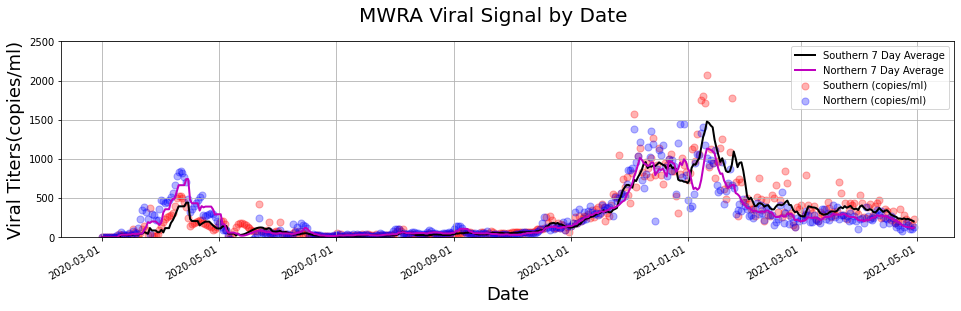

In [10]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.scatter(df_mwra['Date'], df_mwra['Southern (copies/mL)'], color='r', s = 50, alpha=0.3, label="Southern (copies/ml)")
ax.scatter(df_mwra['Date'], df_mwra['Northern (copies/mL)'], color='b', s = 50, alpha=0.3, label="Northern (copies/ml)")
ax.plot(df_mwra['Date'], df_mwra['Southern 7 day avg'], 'k', linewidth = 2,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], df_mwra['Northern 7 day avg'], 'm', linewidth = 2, label="Northern 7 Day Average")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Viral Titers(copies/ml)', fontsize=18)

fig.autofmt_xdate()
fig.suptitle('MWRA Viral Signal by Date', fontsize=20, y=1.00)
fig.show()

In [11]:
# Load Mass-COVID dataset
df_covid= pd.read_excel(MASS_COVID_DATA_FILE,sheet_name='County_Daily', parse_dates=['Date'])
#display(df_covid.tail(5))

df_covid.rename(columns={"New Confirmed Cases": "Cases", "New Probable and Confirmed Deaths": "Deaths"}, inplace=True)
df_covid.drop(['Total Confirmed Cases', 'Total Probable and Confirmed Deaths'], axis=1, inplace=True)

# Add the old-covid 19 values to the dataset
#MASS_COVID_OLD_DATA_FILE=os.path.join(MASS_COVID_DATA_DIR, "covid-19-raw-data-8-5-2020/County.csv")

#df_covid_2 = pd.read_csv(MASS_COVID_OLD_DATA_FILE, parse_dates=['Date'])
#df_covid_2.rename(columns={"Count": "Cases"}, inplace=True)

# Append the two dataframes
#df_covid = df_covid.append(df_covid_2, ignore_index=True)
# Sort by data and re-index
#df_covid = df_covid.sort_values(by="Date")
#df_covid.reset_index(drop=True, inplace=True)

display(df_covid.tail(10))

,Date,County,Cases,Deaths
3990,2021-04-30,Hampden,128.0,5.0
3991,2021-04-30,Hampshire,13.0,0.0
3992,2021-04-30,Middlesex,237.0,2.0
3993,2021-04-30,Nantucket,4.0,NaN
3994,2021-04-30,Norfolk,99.0,0.0
3995,2021-04-30,Plymouth,97.0,1.0
3996,2021-04-30,Suffolk,135.0,3.0
3997,2021-04-30,Worcester,124.0,0.0
3998,2021-04-30,Unknown,-8.0,0.0
3999,2021-04-30,Dukes and Nantucket,NaN,0.0


In [12]:
df_covid.isna().sum()

Date        0
County      0
Cases     252
Deaths    500
dtype: int64

In [13]:
#Impute missing values
df_covid.interpolate(method="akima", limit_direction='both', inplace=True)
# Fill remaining values with 0
df_covid.fillna(0, inplace=True)
df_covid.isna().sum()

Date      0
County    0
Cases     0
Deaths    0
dtype: int64

In [14]:
# Describe the dataset
df_covid.describe()

,Cases,Deaths
count,4000.000000,4000.000000
mean,134.180520,2.818219
std,205.385985,3.510118
min,-69.000000,-1.000000
25%,8.000000,0.000000
50%,43.330750,2.000000
75%,176.000000,4.000000
max,1607.000000,24.000000


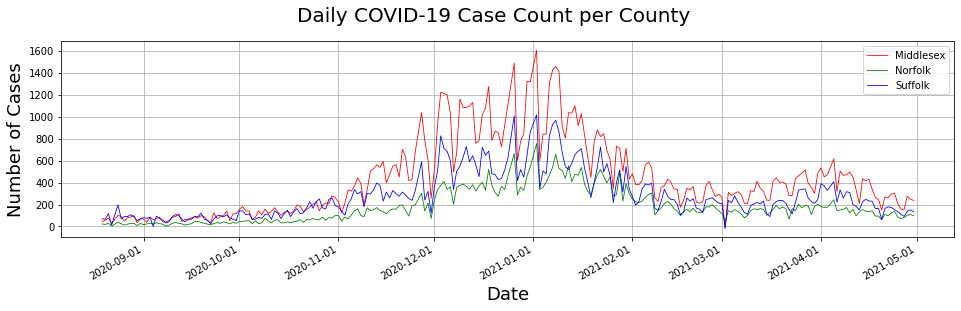

In [15]:
# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

df_ms = df_covid[df_covid['County'].str.contains("Middlesex", case = False)]
df_nr = df_covid[df_covid['County'].str.contains("Norfolk", case = False)]
df_sf = df_covid[df_covid['County'].str.contains("Suffolk", case = False)]

# Plot southern samples
ax.plot(df_ms['Date'], df_ms['Cases'], 'r', linewidth = 0.8, label="Middlesex")
ax.plot(df_ms['Date'], df_nr['Cases'], 'g', linewidth = 0.8, label="Norfolk")
ax.plot(df_ms['Date'], df_sf['Cases'], 'b', linewidth = 0.8, label="Suffolk")


ax.grid(True)
ax.legend()
#ax.set_ylim([0, 2500])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel('Number of Cases', fontsize=18)


fig.autofmt_xdate()
fig.suptitle('Daily COVID-19 Case Count per County', fontsize=20, y=1.00)
fig.show()

In [16]:
df_combined = pd.DataFrame(data=None, columns=['Date', 'Cases', 'Deaths'])

allDates = df_covid['Date'].unique()

for i, i_date in enumerate(allDates):
    totalCases = 0
    totalDeaths = 0

    
    # Add middlesex cases
    row = df_ms[df_ms['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]
        
    # Add norfolk cases
    row = df_nr[df_nr['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    # Add norfolk cases
    row = df_sf[df_sf['Date'] == i_date]
    if not row.empty:
        totalCases += row['Cases'].to_list()[0]
        totalDeaths += row['Deaths'].to_list()[0]

        
    df_combined.at[i, 'Date'] = i_date
    df_combined.at[i, 'Cases'] = totalCases
    df_combined.at[i, 'Deaths'] = totalDeaths

df_combined['Date'] = pd.to_datetime(df_combined['Date'])
display(df_combined)

,Date,Cases,Deaths
0,2020-08-19,135,16
1,2020-08-20,142,3
2,2020-08-21,221,3
3,2020-08-22,41,6
4,2020-08-24,340,13
...,...,...,...
245,2021-04-26,339,5
246,2021-04-27,329,1
247,2021-04-28,514,4
248,2021-04-29,507,5


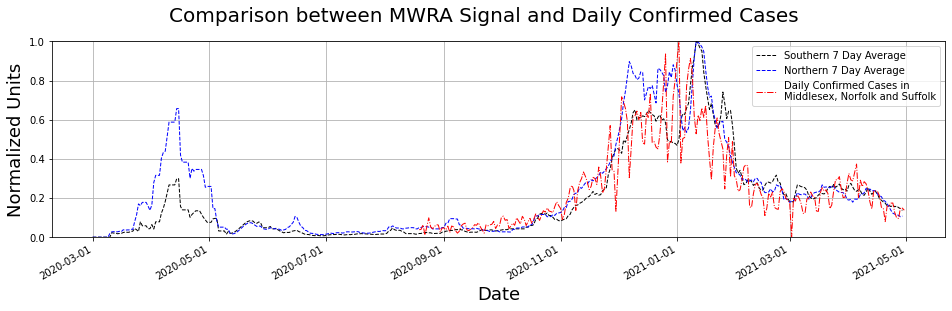

In [17]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_mwra['Date'], normalize(df_mwra['Southern 7 day avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_mwra['Date'], normalize(df_mwra['Northern 7 day avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_combined['Date'], normalize(df_combined['Cases'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_combined['Date'], normalize(df_combined['Deaths'].to_numpy()), '-.b', linewidth = 1, label="Daily Confirmed Deaths in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

In [18]:
# Create algined matrix between southern, northen and covid cases
df_aligned = pd.DataFrame(data=None, columns=['Date', 'Southern Raw', 'Northern Raw', 
                                              'Southern Avg', 'Northern Avg', 
                                                'Southern Variant', 'Northern Variant',
                                              'Cases', 'Deaths'])

covidDates = df_covid['Date'].unique()
mwraDates = df_mwra['Date'].unique()
commonDates = np.intersect1d(covidDates, mwraDates)

for i, i_date in enumerate(commonDates):
    total = 0
    
    row = df_mwra[df_mwra['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Southern Raw'] = row['Southern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Northern Raw'] = row['Northern (copies/mL)'].to_list()[0]
        df_aligned.at[i, 'Southern Avg'] = row['Southern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Northern Avg'] = row['Northern 7 day avg'].to_list()[0]
        df_aligned.at[i, 'Southern Variant'] = row['Southern Variant Results'].to_list()[0]
        df_aligned.at[i, 'Northern Variant'] = row['Northern Variant Results'].to_list()[0]
        
        
    row = df_combined[df_combined['Date'] == i_date]
    if not row.empty:
        df_aligned.at[i, 'Cases'] = row['Cases'].to_list()[0]
        df_aligned.at[i, 'Deaths'] = row['Deaths'].to_list()[0]
        
    df_aligned.at[i, 'Date'] = i_date

# Reformat dates
df_aligned['Date'] = pd.to_datetime(df_aligned['Date'])

In [19]:
# Scale confirmed cases by population per 100,000
MIDDLESEX_POPULATION = 1611699
NORFOLK_POPULATION = 11786
SUFFOLK_POPULATION = 803907
MASS_POPULATION = (MIDDLESEX_POPULATION + NORFOLK_POPULATION + SUFFOLK_POPULATION) / 100000

df_aligned['Cases_per_100K'] = df_aligned['Cases'] / MASS_POPULATION
df_aligned['Deaths_per_100K'] = df_aligned['Deaths'] / MASS_POPULATION

In [20]:
display(df_aligned.head())

,Date,Southern Raw,Northern Raw,Southern Avg,Northern Avg,Southern Variant,Northern Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K
0,2020-08-19,50,87,28,56,0,0,135,16,5.56152,0.659144
1,2020-08-20,43.0683,74.2871,28,56,0,0,142,3,5.8499,0.123589
2,2020-08-21,35,60,35,61,0,0,221,3,9.10442,0.123589
3,2020-08-22,28.5253,49.5942,35,61,0,0,41,6,1.68906,0.247179
4,2020-08-24,21,38,33,58,0,0,340,13,14.0068,0.535554


Text(0.5, 1.05, 'Relationship plot between Southern Titers and New Confirmed Cases')

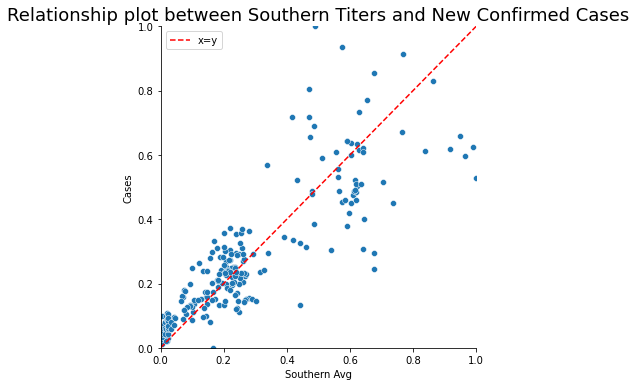

In [21]:
# Scale the values
df_scaled = df_aligned.copy()
scaler = MinMaxScaler()
df_scaled[['Southern Raw', 'Northern Raw','Southern Avg', 'Northern Avg','Cases', 'Deaths']] = scaler.fit_transform(df_aligned[['Southern Raw', 'Northern Raw', 
                                                                                                                    'Southern Avg', 'Northern Avg',
                                                                                                                           'Cases_per_100K', 'Deaths_per_100K']])
# Show the relation between norther and souther samples
sns.relplot(data=df_scaled, x="Southern Avg", y="Cases")
plt.plot([0,1], [0,1], '--r', label="x=y")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend()
plt.title('Relationship plot between Southern Titers and New Confirmed Cases', fontsize=18, y=1.05)

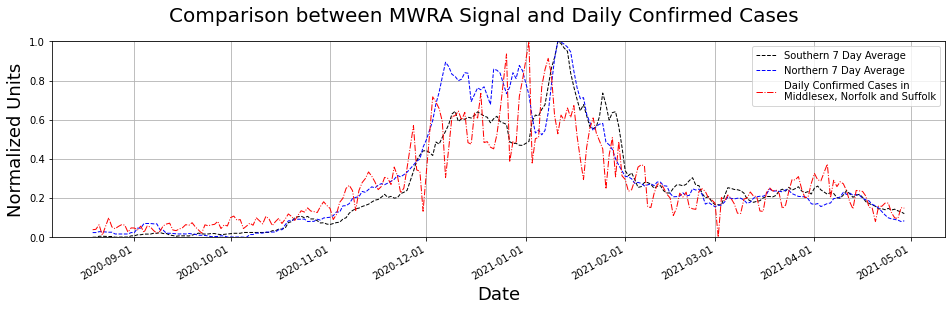

In [22]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], normalize(df_aligned['Southern Avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Northern Avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Cases'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

In [23]:
# Compute 7 day moving average for cases and deaths
df_aligned['Cases Avg'] = df_aligned['Cases'].rolling(window=7).mean()
df_aligned['Deaths Avg'] = df_aligned['Deaths'].rolling(window=7).mean()

# Interpolate head
df_aligned.interpolate(limit_direction="both", inplace=True)

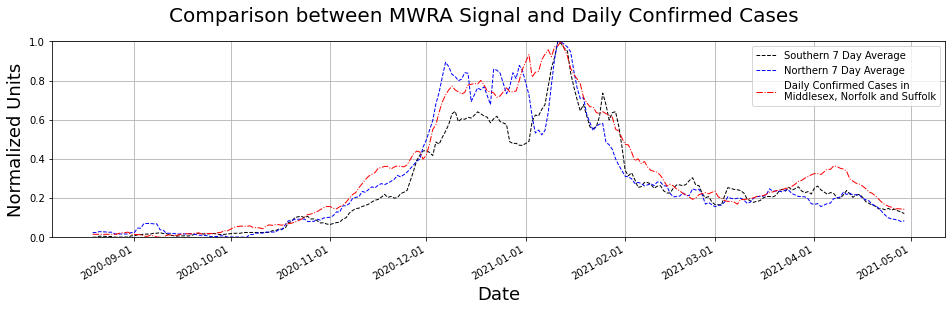

In [24]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
ax.plot(df_aligned['Date'], normalize(df_aligned['Southern Avg'].to_numpy()), '--k', linewidth = 1,  label="Southern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Northern Avg'].to_numpy()), '--b', linewidth = 1, label="Northern 7 Day Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Cases Avg'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

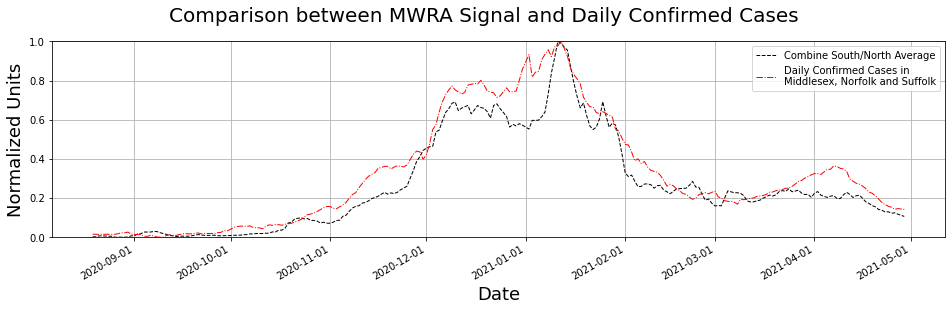

In [25]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Plot the timeseries data

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

# Plot southern samples
sn_combine = df_aligned['Southern Avg'] + df_aligned['Northern Avg'] / 2
ax.plot(df_aligned['Date'], normalize(sn_combine.to_numpy()), '--k', linewidth = 1,  label="Combine South/North Average")
ax.plot(df_aligned['Date'], normalize(df_aligned['Cases Avg'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.set_ylim([0, 1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Normalized Units', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Comparison between MWRA Signal and Daily Confirmed Cases', fontsize=20, y=1.00)
fig.show()

# Modeling


In [26]:
# Split Dataset into train and test
TRAIN_PERCENTAGE = 0.7;
train_size = int(len(df_aligned) * TRAIN_PERCENTAGE)

df_train, df_test = np.split(df_aligned, [int(TRAIN_PERCENTAGE*len(df_aligned))])
print('Train Size: {}'.format(len(df_train)))
print('Test Size: {}'.format(len(df_test)))

Train Size: 174
Test Size: 75


# Persistence Model

In [27]:
# Create lagged dataset
def persistence_values(x):
    x = pd.DataFrame(x)
    df = pd.concat([x.shift(1), x], axis=1)
    df.columns = ['x', 'y']
    return df

train = persistence_values(df_train['Cases'])
test = persistence_values(df_test['Cases'])

train_X, train_y = train.iloc[:,0], train.iloc[:,1]
test_X, test_y = test.iloc[:,0], test.iloc[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = [ model_persistence(x) for x in test_X ]
test_score = mean_squared_error(test_y[1:], predictions[1:])
print('Test MSE: %.3f' % test_score)

Test MSE: 37707.865


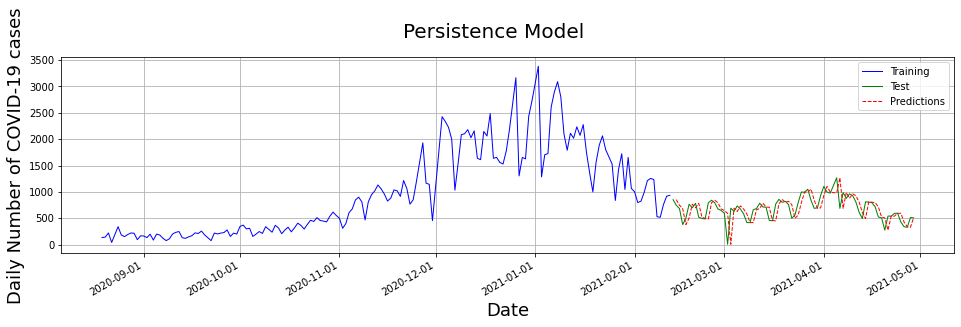

In [28]:
# plot predictions and expected results
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(16,4))

ax.plot(df_train['Date'], train_y, 'b', linewidth = 1,  label="Training")
ax.plot(df_test['Date'], test_y, 'g', linewidth = 1,  label="Test")
ax.plot(df_test['Date'], predictions, '--r', linewidth = 1,  label="Predictions")
#ax.plot(df_aligned['Date'], normalize(df_aligned['Deaths_per_100K'].to_numpy()), '-.r', linewidth = 1, label="Daily Confirmed Cases in \nMiddlesex, Norfolk and Suffolk")

ax.grid(True)
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel('Daily Number of COVID-19 cases', fontsize = 18)
ax.set_xlabel('Date', fontsize = 18)


fig.autofmt_xdate()
fig.suptitle('Persistence Model', fontsize=20, y=1.00)
fig.show()

In [29]:
# Linear Regression Model
X = df_train[['Southern Raw', 'Northern Raw']].astype('float')
y = df_train['Cases'].astype('float')

X = sm.add_constant(X) # adding a constant
model_lm1 = sm.OLS(y, X).fit()

# Print summary
model_lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Cases   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     245.6
Date:                Thu, 06 May 2021   Prob (F-statistic):           5.30e-51
Time:                        00:44:28   Log-Likelihood:                -1293.5
No. Observations:                 174   AIC:                             2593.
Df Residuals:                     171   BIC:                             2603.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          244.3242     45.516      5.368      0.000     154.479     334.170
Southern Raw     0.3476      0.096      3.623      0.000       0.158       0.537
Northern Raw     1.3942      0.124     11.210      0.000       1.149       1.640
==============================================================================
Omnibus:                       81.646   Durbin-Watson:                   1.541
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              605.207
Skew:                           1.545   Prob(JB):                    3.81e-132
Kurtosis:                      11.598   Cond. No.                     1.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#XGBOOST TIME SERIES

In [38]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree


In [39]:
df_train

,Date,Southern Raw,Northern Raw,Southern Avg,Northern Avg,Southern Variant,Northern Variant,Cases,Deaths,Cases_per_100K,Deaths_per_100K,Cases Avg,Deaths Avg
0,2020-08-19,50,87,28,56,0,0,135,16,5.56152,0.659144,173.428571,7.857143
1,2020-08-20,43.0683,74.2871,28,56,0,0,142,3,5.8499,0.123589,173.428571,7.857143
2,2020-08-21,35,60,35,61,0,0,221,3,9.10442,0.123589,173.428571,7.857143
3,2020-08-22,28.5253,49.5942,35,61,0,0,41,6,1.68906,0.247179,173.428571,7.857143
4,2020-08-24,21,38,33,58,0,0,340,13,14.0068,0.535554,173.428571,7.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2021-02-08,492,412,432,324,0,0,529,22,21.7929,0.906323,978.000000,24.714286
170,2021-02-09,347,315,420,330,0,0,518,27,21.3398,1.1123,938.000000,26.714286
171,2021-02-10,213,225,390,320,0,0,758,34,31.2269,1.40068,928.571429,29.000000
172,2021-02-11,471,382,405,340,0,0,918,23,37.8184,0.947519,918.142857,27.857143


In [40]:
xg_train=df_train.iloc[:,0:3]
xg_train["Cases"]=df_train.Cases
xg_test=df_test.iloc[:,0:3]
xg_test["Cases"]=df_test.Cases


In [41]:
xg_test

,Date,Southern Raw,Northern Raw,Cases
174,2021-02-13,265,285,853
175,2021-02-14,543,283,747
176,2021-02-15,500,155,683
177,2021-02-16,663,190,379
178,2021-02-17,326,232,504
...,...,...,...,...
244,2021-04-25,238,176,429
245,2021-04-26,209,154,339
246,2021-04-27,139,107,329
247,2021-04-28,157,102,514


In [42]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date']=df['Date']
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['Southern Raw']=df['Southern Raw'].astype(int)
    df['Northern Raw']=df['Northern Raw'].astype(int)

    
    X = df[['Southern Raw','Northern Raw','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [43]:
X_train_xg, y_train_xg = create_features(xg_train, label='Cases')
X_test_xg, y_test_xg = create_features(xg_test, label='Cases')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if sys.path[0] == '':


In [44]:
X_train_xg

,Southern Raw,Northern Raw,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,50,87,2,3,8,2020,232,19,34
1,43,74,3,3,8,2020,233,20,34
2,35,60,4,3,8,2020,234,21,34
3,28,49,5,3,8,2020,235,22,34
4,21,38,0,3,8,2020,237,24,35
...,...,...,...,...,...,...,...,...,...
169,492,412,0,1,2,2021,39,8,6
170,347,315,1,1,2,2021,40,9,6
171,213,225,2,1,2,2021,41,10,6
172,471,382,3,1,2,2021,42,11,6


In [45]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train_xg, y_train_xg,
        eval_set=[(X_train_xg, y_train_xg), (X_test_xg, y_test_xg)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train


[00:47:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

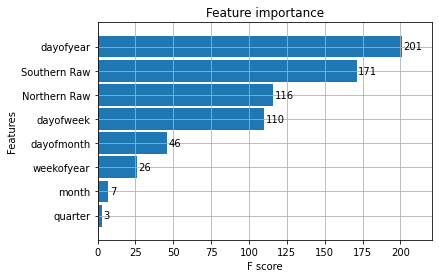

In [46]:
_ = plot_importance(reg, height=0.9)

In [47]:
# Function to plot actual future against prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction), label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Day')
    plt.ylabel('Daily Cases')

In [48]:
pred = reg.predict(X_test_xg)

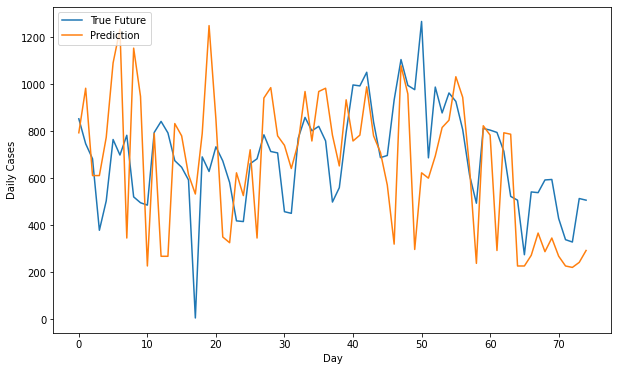

In [49]:
plot_future(pred.tolist(), y_test_xg.tolist())

#XGBOOST TIME SERIES with fewer parameters



In [77]:
#Removed day of year from this df

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['Southern Raw']=df['Southern Raw'].astype(int)
    df['Northern Raw']=df['Northern Raw'].astype(int)

    
    X = df[['Southern Raw','Northern Raw','dayofweek','month','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [78]:
X_train_xg, y_train_xg = create_features(xg_train, label='Cases')
X_test_xg, y_test_xg = create_features(xg_test, label='Cases')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [79]:
X_train_xg

,Southern Raw,Northern Raw,dayofweek,month,dayofmonth,weekofyear
0,50,87,2,8,19,34
1,43,74,3,8,20,34
2,35,60,4,8,21,34
3,28,49,5,8,22,34
4,21,38,0,8,24,35
...,...,...,...,...,...,...
169,492,412,0,2,8,6
170,347,315,1,2,9,6
171,213,225,2,2,10,6
172,471,382,3,2,11,6


In [80]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train_xg, y_train_xg,
        eval_set=[(X_train_xg, y_train_xg), (X_test_xg, y_test_xg)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train


[01:59:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

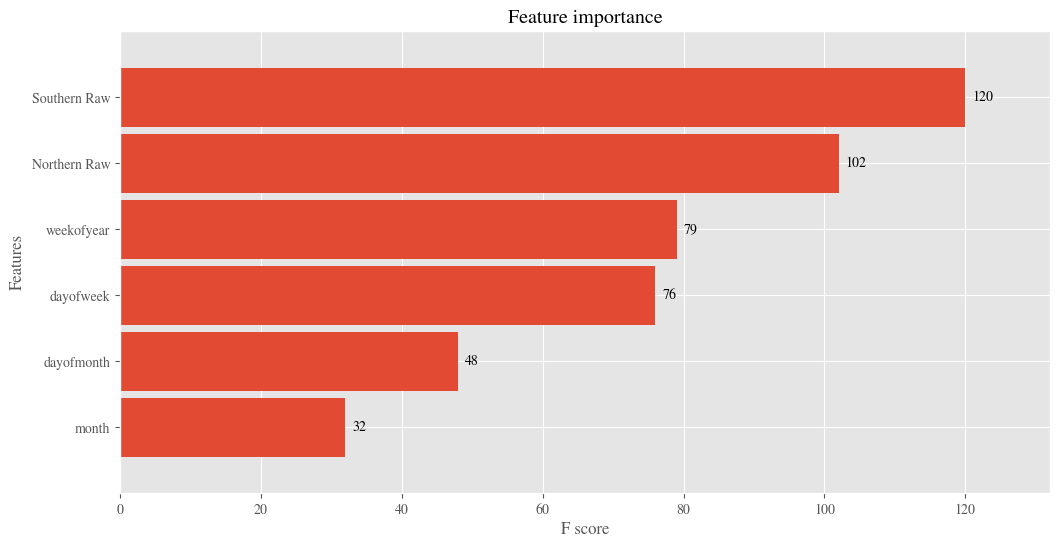

In [81]:
_ = plot_importance(reg, height=0.9)

In [82]:
# Function to plot actual future against prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction), label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Day')
    plt.ylabel('Daily Cases')

In [83]:
pred = reg.predict(X_test_xg)

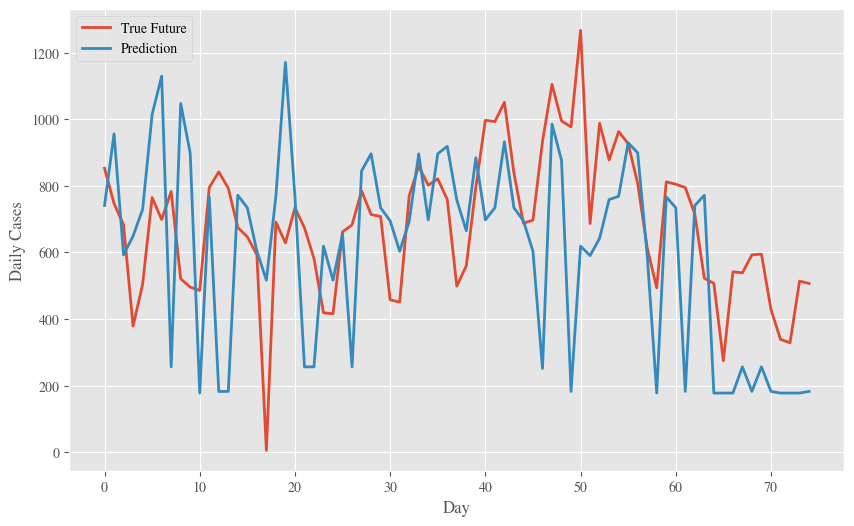

In [84]:
plot_future(pred.tolist(), y_test_xg.tolist())

#Time series analysis

In [50]:
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

# Remove border function taken from CS109 2013 
######################################
def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()
    

In [51]:
mpl.rcParams.update(mpl.rcParamsDefault)
set_mpl_params()
mpl.style.use('ggplot')

In [52]:
#Creating a dataframe with time/day as index and cases on that day
y_train_df=pd.DataFrame(data=y_train, index=np.arange(len(y_train)), columns=["cases"])
y_train_df.index.name = 't'

y_test_df=pd.DataFrame(data=y_test, index=np.arange(len(y_test)), columns=["cases"])
y_test_df.index.name = 't'

In [53]:
y_train_df.head()

,cases
t,
0,0.028135
1,0.030230
2,0.053876
3,0.000000
4,0.089494


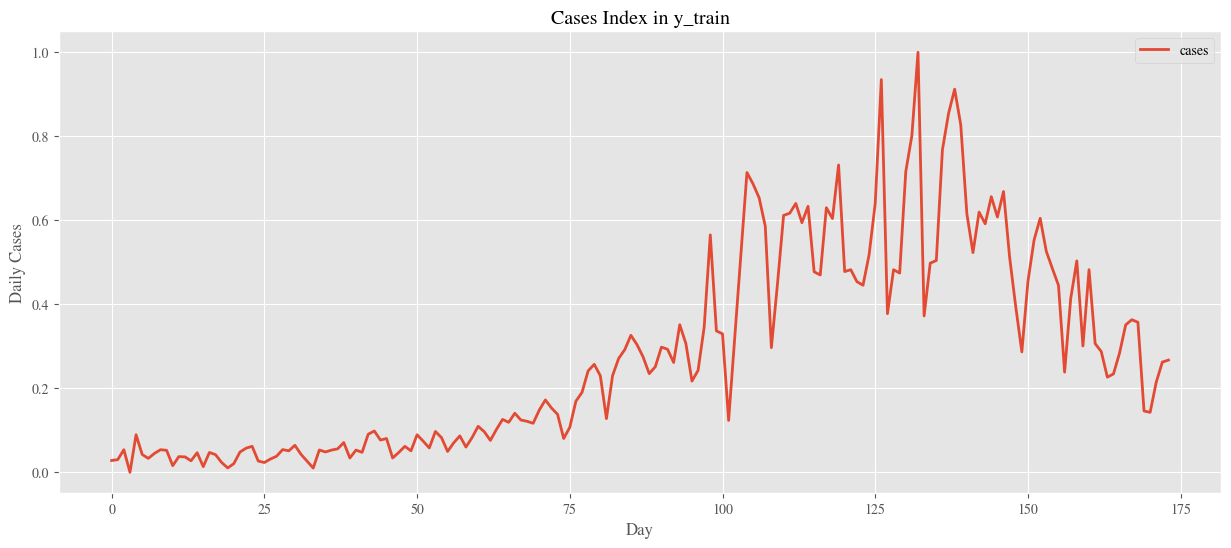

In [54]:
y_train_df.plot(figsize=(15, 6),title='Cases Index in y_train')
plt.xlabel('Day')
plt.ylabel('Daily Cases')
plt.show()

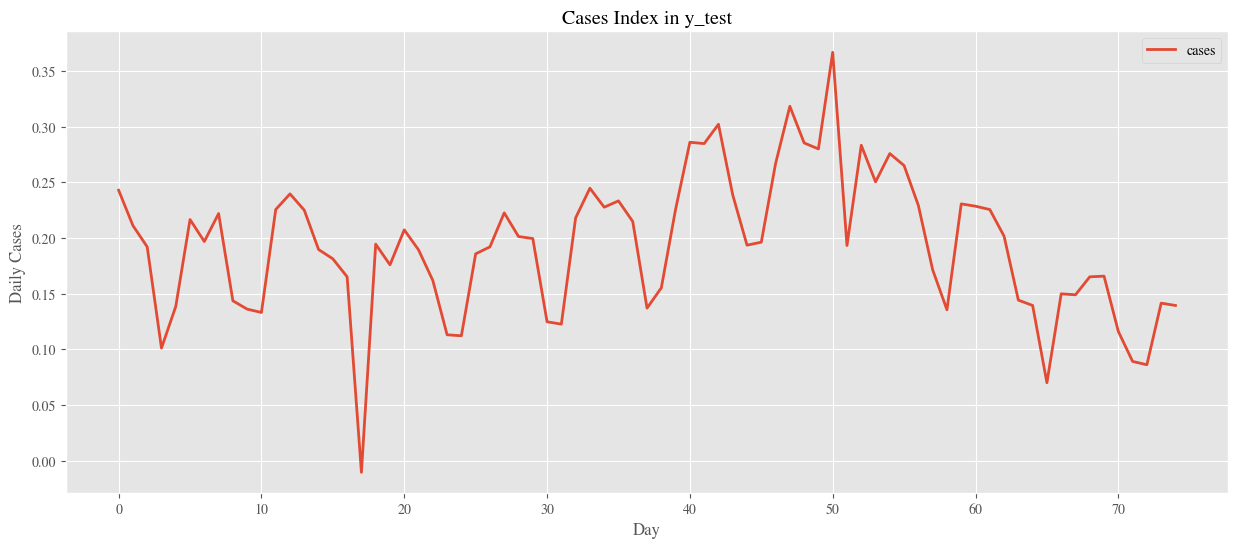

In [55]:
y_test_df.plot(figsize=(15, 6),title='Cases Index in y_test')
plt.xlabel('Day')
plt.ylabel('Daily Cases')
plt.show()

#### Analysing y_train cases

In [56]:
#Transforming case data to log and differencing to make the data stationary
y_train_df['ln_cases']=np.log(y_train_df['cases']) 
y_train_df['ln_cases_diff'] = y_train_df['ln_cases'].diff() 
y_train_df.dropna(inplace=True)

y_train_df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,cases,ln_cases,ln_cases_diff
t,,,
1,0.030230,-3.498905,0.071826
2,0.053876,-2.921069,0.577836
3,0.000000,-inf,-inf
4,0.089494,-2.413582,inf
5,0.042502,-3.158198,-0.744617


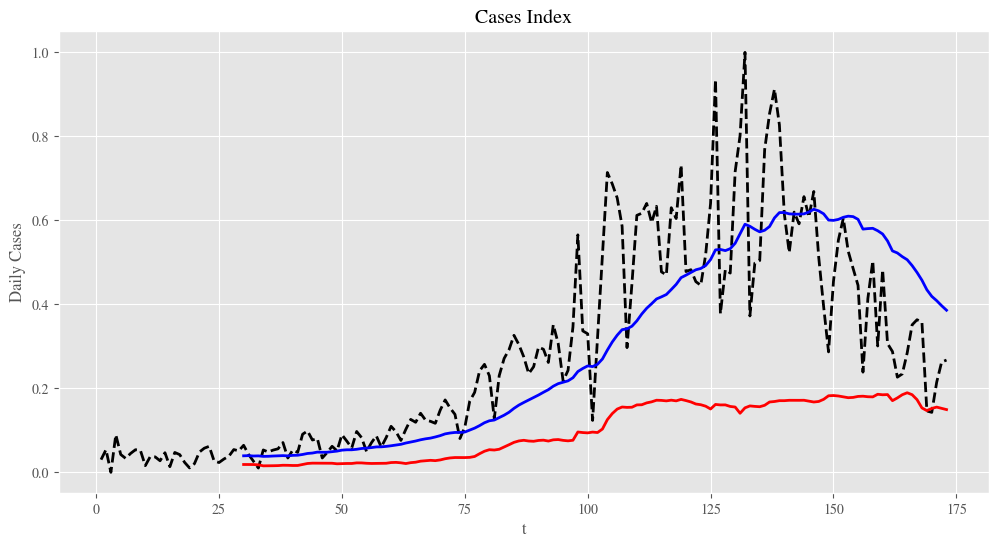

In [57]:
#plot the time series
y_train_df['cases'].plot(style='k--', title='Cases Index')
plt.xlabel('Day')
plt.ylabel('Daily Cases')

# calculate 30 day rolling mean and std and plot. 
y_train_df['cases'].rolling(window=30).std().plot(style='r')
y_train_df['cases'].rolling(window=30).mean().plot(style='b')
plt.show()


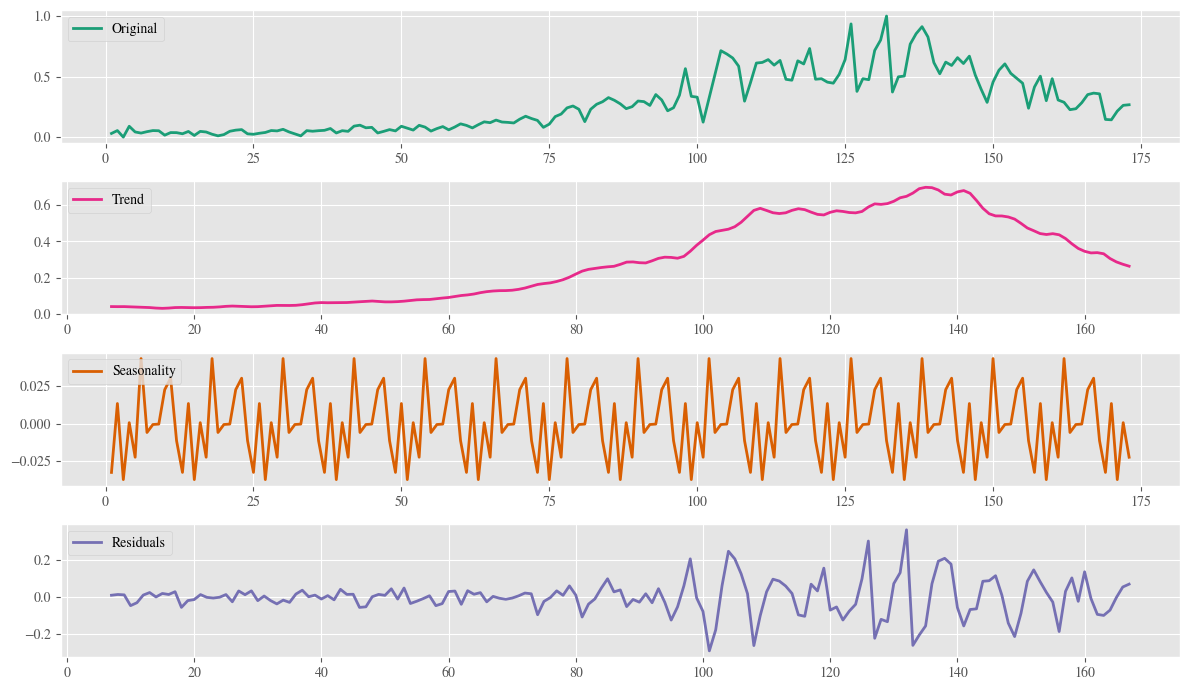

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Method to decompose the original data into trend, seasonality and residuals
def breakout_plots(seas_series):
    decomposition = seasonal_decompose(seas_series,freq=12) 

    f, ax = plt.subplots(1,4,figsize=(12, 7))

    plt.subplot(411)
    plt.plot(seas_series, label='Original', c=dark2_colors[0])
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', c=dark2_colors[1])
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality', c=dark2_colors[2])
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', c=dark2_colors[3])
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return decomposition

decomposition = breakout_plots(y_train_df['cases'])


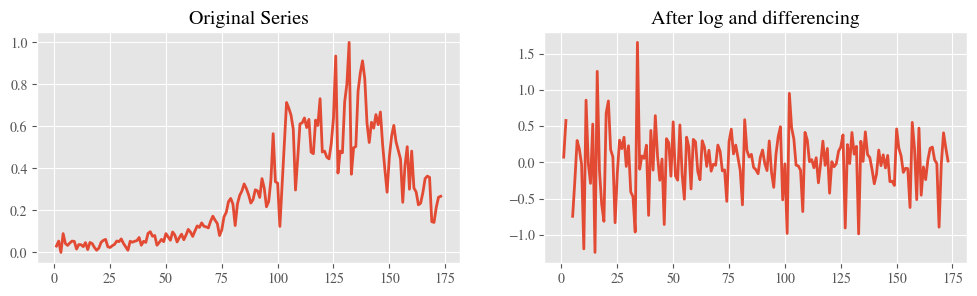

In [59]:
f, ax = plt.subplots(1, 2,figsize=(12, 3))
ax[0].plot(y_train_df['cases']);
ax[0].set_title('Original Series')
ax[1].plot(y_train_df['ln_cases_diff']);
ax[1].set_title('After log and differencing');
plt.show()

In [60]:
#@title

"""
#Transforming production data to log and differencing to make the data stationary
y_test_df['ln_cases']=np.log(y_test_df['cases']) 
y_test_df['ln_cases_diff'] = y_test_df['ln_cases'].diff() 
y_test_df.dropna(inplace=True)

y_test_df.head()

#plot the time series
y_test_df['cases'].plot(style='k--', title='Cases Index')
plt.xlabel('Day')
plt.ylabel('Daily Cases')

# calculate 30 day rolling mean and std and plot. 
y_test_df['cases'].rolling(window=30).std().plot(style='r')
y_test_df['cases'].rolling(window=30).mean().plot(style='b')
plt.show()
"""

"\n#Transforming production data to log and differencing to make the data stationary\ny_test_df['ln_cases']=np.log(y_test_df['cases']) \ny_test_df['ln_cases_diff'] = y_test_df['ln_cases'].diff() \ny_test_df.dropna(inplace=True)\n\ny_test_df.head()\n\n#plot the time series\ny_test_df['cases'].plot(style='k--', title='Cases Index')\nplt.xlabel('Day')\nplt.ylabel('Daily Cases')\n\n# calculate 30 day rolling mean and std and plot. \ny_test_df['cases'].rolling(window=30).std().plot(style='r')\ny_test_df['cases'].rolling(window=30).mean().plot(style='b')\nplt.show()\n"

#### Creating time series models:

In [61]:
def tsplot(y, lags=None, figsize=(12, 12)):
    
    q, p = sm.stats.diagnostic.acorr_ljungbox(y,lags)
    fig = plt.figure(figsize=figsize)
    layout = (4, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0), colspan=2, title='QQ plot')
    lbox_ax = plt.subplot2grid(layout, (3, 0), colspan=2, title='Ljung-Box statistic')

    y.plot(ax=ts_ax, title='Residuals')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    qqplot(y,  line='q', ax=qq_ax, fit=True)
    if np.max(p) > 0.05:
        lbox_ax.axhline(y=0.05, xmin=0, xmax=lags, c ='r')
    lbox_ax.plot(p)
    seaborn.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax, lbox_ax

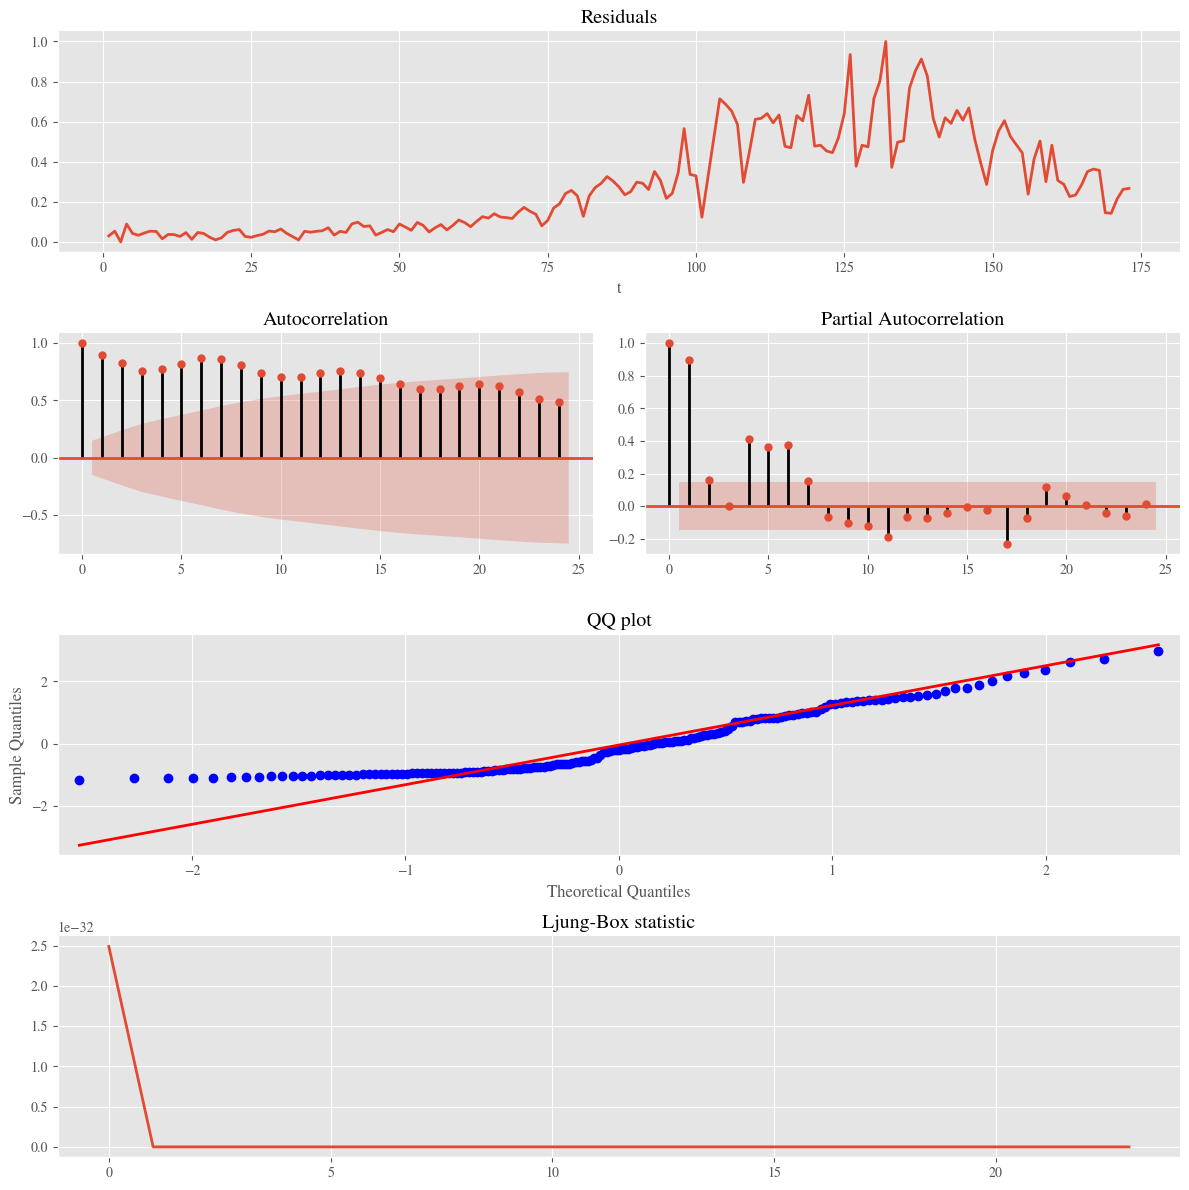

In [62]:
_ = tsplot(y_train_df['cases'],24)

In [63]:
#Dropping +/-inf from train set after making the data stationary
y_train_df['ln_cases_diff']
y_train_df1=y_train_df[~y_train_df.isin([np.nan, np.inf, -np.inf]).any(1)]
y_train_df1

,cases,ln_cases,ln_cases_diff
t,,,
1,0.030230,-3.498905,0.071826
2,0.053876,-2.921069,0.577836
5,0.042502,-3.158198,-0.744617
6,0.033224,-3.404495,-0.246297
7,0.044897,-3.103390,0.301105
...,...,...,...
169,0.146064,-1.923710,-0.894749
170,0.142772,-1.946509,-0.022799
171,0.214606,-1.538950,0.407559


In [66]:
from itertools import product
from tqdm import tqdm_notebook

#Set initial values and some bounds
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

SARIMA helper code referenced from: https://github.com/marcopeix/stock-prediction/blob/master/Stock%20Prediction.ipynb 

In [ ]:
from tqdm import tqdm_notebook, tnrange

def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm.tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(y_train_df1.cases, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    print(result_table.head())
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

In [71]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)

p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(y_train_df1.cases, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                 Statespace Model Results                                
Dep. Variable:                             cases   No. Observations:                  171
Model:             SARIMAX(3, 1, 2)x(0, 1, 1, 5)   Log Likelihood                 160.809
Date:                           Thu, 06 May 2021   AIC                           -307.617
Time:                                   01:27:42   BIC                           -285.876
Sample:                                        0   HQIC                          -298.792
                                           - 171                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6537      0.101      6.449      0.000       0.455       0.852
ar.L2         -0.3260      0.113     -2.891

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [72]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_SARIMA(series, model, n_steps):
    """
        Plot model vs predicted values
        
        series - dataset with time series
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
    """
    
    data = series.copy().rename(columns = {'CLOSE': 'actual'})
    data['arima_model'] = model.fittedvalues
    #Make a shift on s+d steps, because these values were unobserved by the model due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    #Forecast on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    forecast = data.arima_model.append(forecast)
    #Calculate error
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(17, 8))
    plt.title('Mean Absolute Percentage Error: {0:.2f}%'.format(error))
    plt.plot(forecast, color='r', label='model')
    plt.axvspan(data.index[-1], forecast.index[-1],alpha=0.5, color='lightgrey')
    plt.plot(data, label='actual')
    plt.legend()
    plt.grid(True);
    
# plot_SARIMA(data, best_model, 5)
print(best_model.predict(start=y_train_df1.cases.shape[0], end=y_train_df1.cases.shape[0] + 78))
print(mean_absolute_percentage_error(y_train_df1.cases[s+d:], best_model.fittedvalues[s+d:]))

171    0.262661
172    0.220609
173    0.183006
174    0.180156
175    0.188233
         ...   
245    0.198909
246    0.189933
247    0.197349
248    0.203586
249    0.215185
Length: 79, dtype: float64
28.612808126398914


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [73]:
#Making predictions using training data and comparing to the test set
pred=best_model.predict(start=y_train_df1.cases.shape[0], end=y_train_df1.cases.shape[0] + 78)
pred=pred.loc[175:]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [74]:
comparison = pd.DataFrame({'actual': list(y_test_df.cases),
                          'predicted': list(pred)},)

In [75]:
comparison.head()


,actual,predicted
0,0.243041,0.188233
1,0.211314,0.221192
2,0.192158,0.254382
3,0.101167,0.252263
4,0.138581,0.231502


No handles with labels found to put in legend.


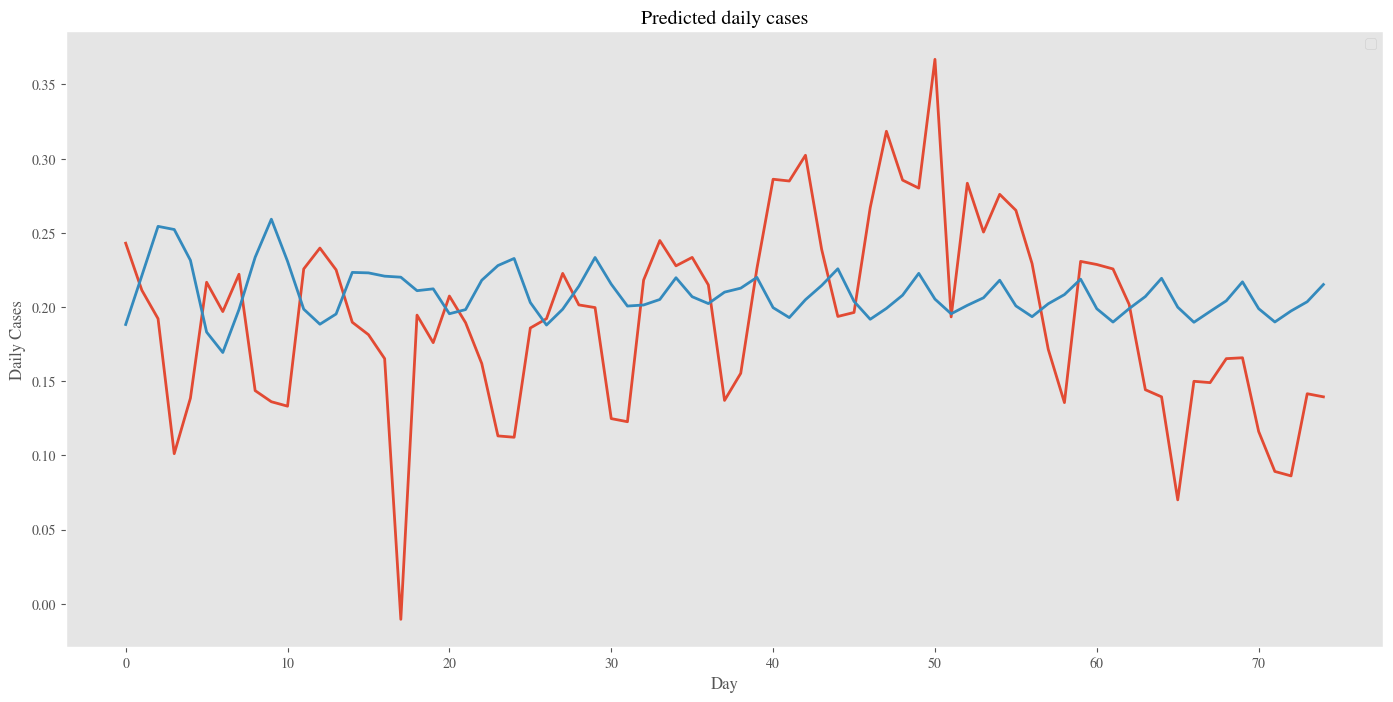

In [76]:
plt.figure(figsize=(17, 8))
plt.plot(comparison.actual)
plt.plot(comparison.predicted)
plt.title('Predicted daily cases')
plt.ylabel('Daily Cases')
plt.xlabel('Day')
plt.legend(loc='best')
plt.grid(False)
plt.show()